In [1]:
import os
import pickle

# Functions from other notebook file.
from ipynb.fs.full.shared_functions_server import *

2021-12-05 18:20:24.498939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:24.531751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:24.531960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:24.532649: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

In [2]:
# Move one directory back to the project root.
os.chdir("..")

In [3]:
# Suppress tensorflow log messages.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
# GLOBALS
DATA_DIRECTORY = os.path.join(os.getcwd() + '/datasets/unseen-samples')
BATCH_SIZE = 128

IMAGE_HEIGHT = 100
IMAGE_WIDTH = 100
IMAGE_CHANNELS = 1

CATEGORIES = 10 # represents digits 0-9
DIMENSIONS = 4

---
## Evaluate Model History

In [5]:
# Open serialized training history data for VGG-16 model.
with open(r'model-info/heterogeneous-solver-history', 'rb') as input_file:
            history = pickle.load(input_file, encoding='bytes')

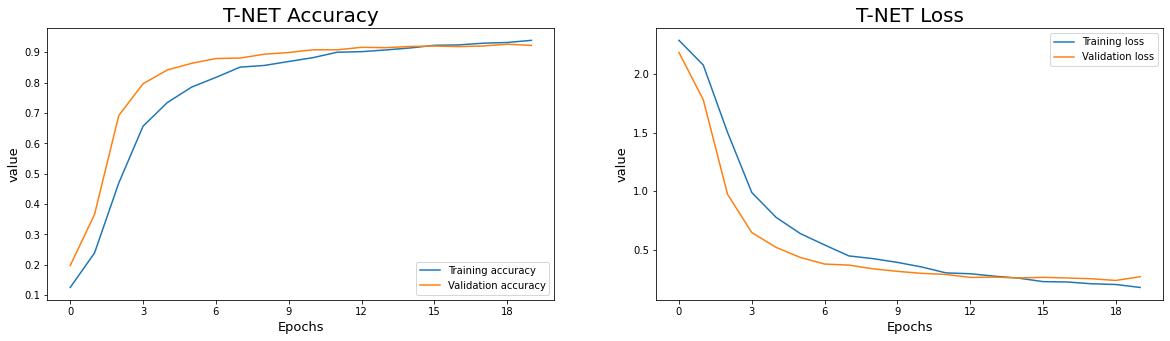

In [6]:
# Plot the training history.
title_font = 20
axis_font = 13

figure, axes = pyplot.subplots(1, 2, figsize=(20, 5))

axes[0].set_xticks(range(0, 21, 3))
axes[0].plot(history['accuracy'], label='Training accuracy')
axes[0].plot(history['val_accuracy'], label='Validation accuracy')
axes[0].set_title('T-NET Accuracy', fontsize=20)
axes[0].set_xlabel('Epochs', fontsize=axis_font)
axes[0].set_ylabel('value', fontsize=axis_font)
axes[0].legend() 

axes[1].set_xticks(range(0, 21, 3))
axes[1].plot(history['loss'], label='Training loss')
axes[1].plot(history['val_loss'], label='Validation loss')
axes[1].set_title('T-NET Loss', fontsize=20)
axes[1].set_xlabel('Epochs', fontsize=axis_font)
axes[1].set_ylabel('value', fontsize=axis_font)
axes[1].legend()

---
## Evaluate Model Performance

In [7]:
model = models.load_model('model-info/heterogeneous-solver')
model.summary()

2021-12-05 18:20:54.339204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:54.339618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:54.339928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:54.340316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:54.340638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Model: "T-NET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 100, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 25, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 22400)             0         
                                                                 
 dense (Dense)               (None, 1024)              229386

In [8]:
data_frame = create_captcha_dataframe(DATA_DIRECTORY)
data_frame.head()

,label,file
0,2271,/mnt/wd-blue/captcha-tensorflow/datasets/unsee...
1,4580,/mnt/wd-blue/captcha-tensorflow/datasets/unsee...
2,3387,/mnt/wd-blue/captcha-tensorflow/datasets/unsee...
3,4033,/mnt/wd-blue/captcha-tensorflow/datasets/unsee...
4,6787,/mnt/wd-blue/captcha-tensorflow/datasets/unsee...


In [9]:
shuffled_indices = numpy.random.permutation(len(data_frame))
print('Test set:', len(shuffled_indices))

Test set: 30000


In [10]:
testing_set_generator = get_alternate_captcha_generator(data_frame, shuffled_indices, 
                                                        for_training=False, batch_size=BATCH_SIZE)
captcha_images, captcha_text = next(testing_set_generator)

predictions = model.predict_on_batch(captcha_images)

true_values = tensorflow.math.argmax(captcha_text, axis=-1)
predictions = tensorflow.math.argmax(predictions, axis=-1)

2021-12-03 23:37:50.111075: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300


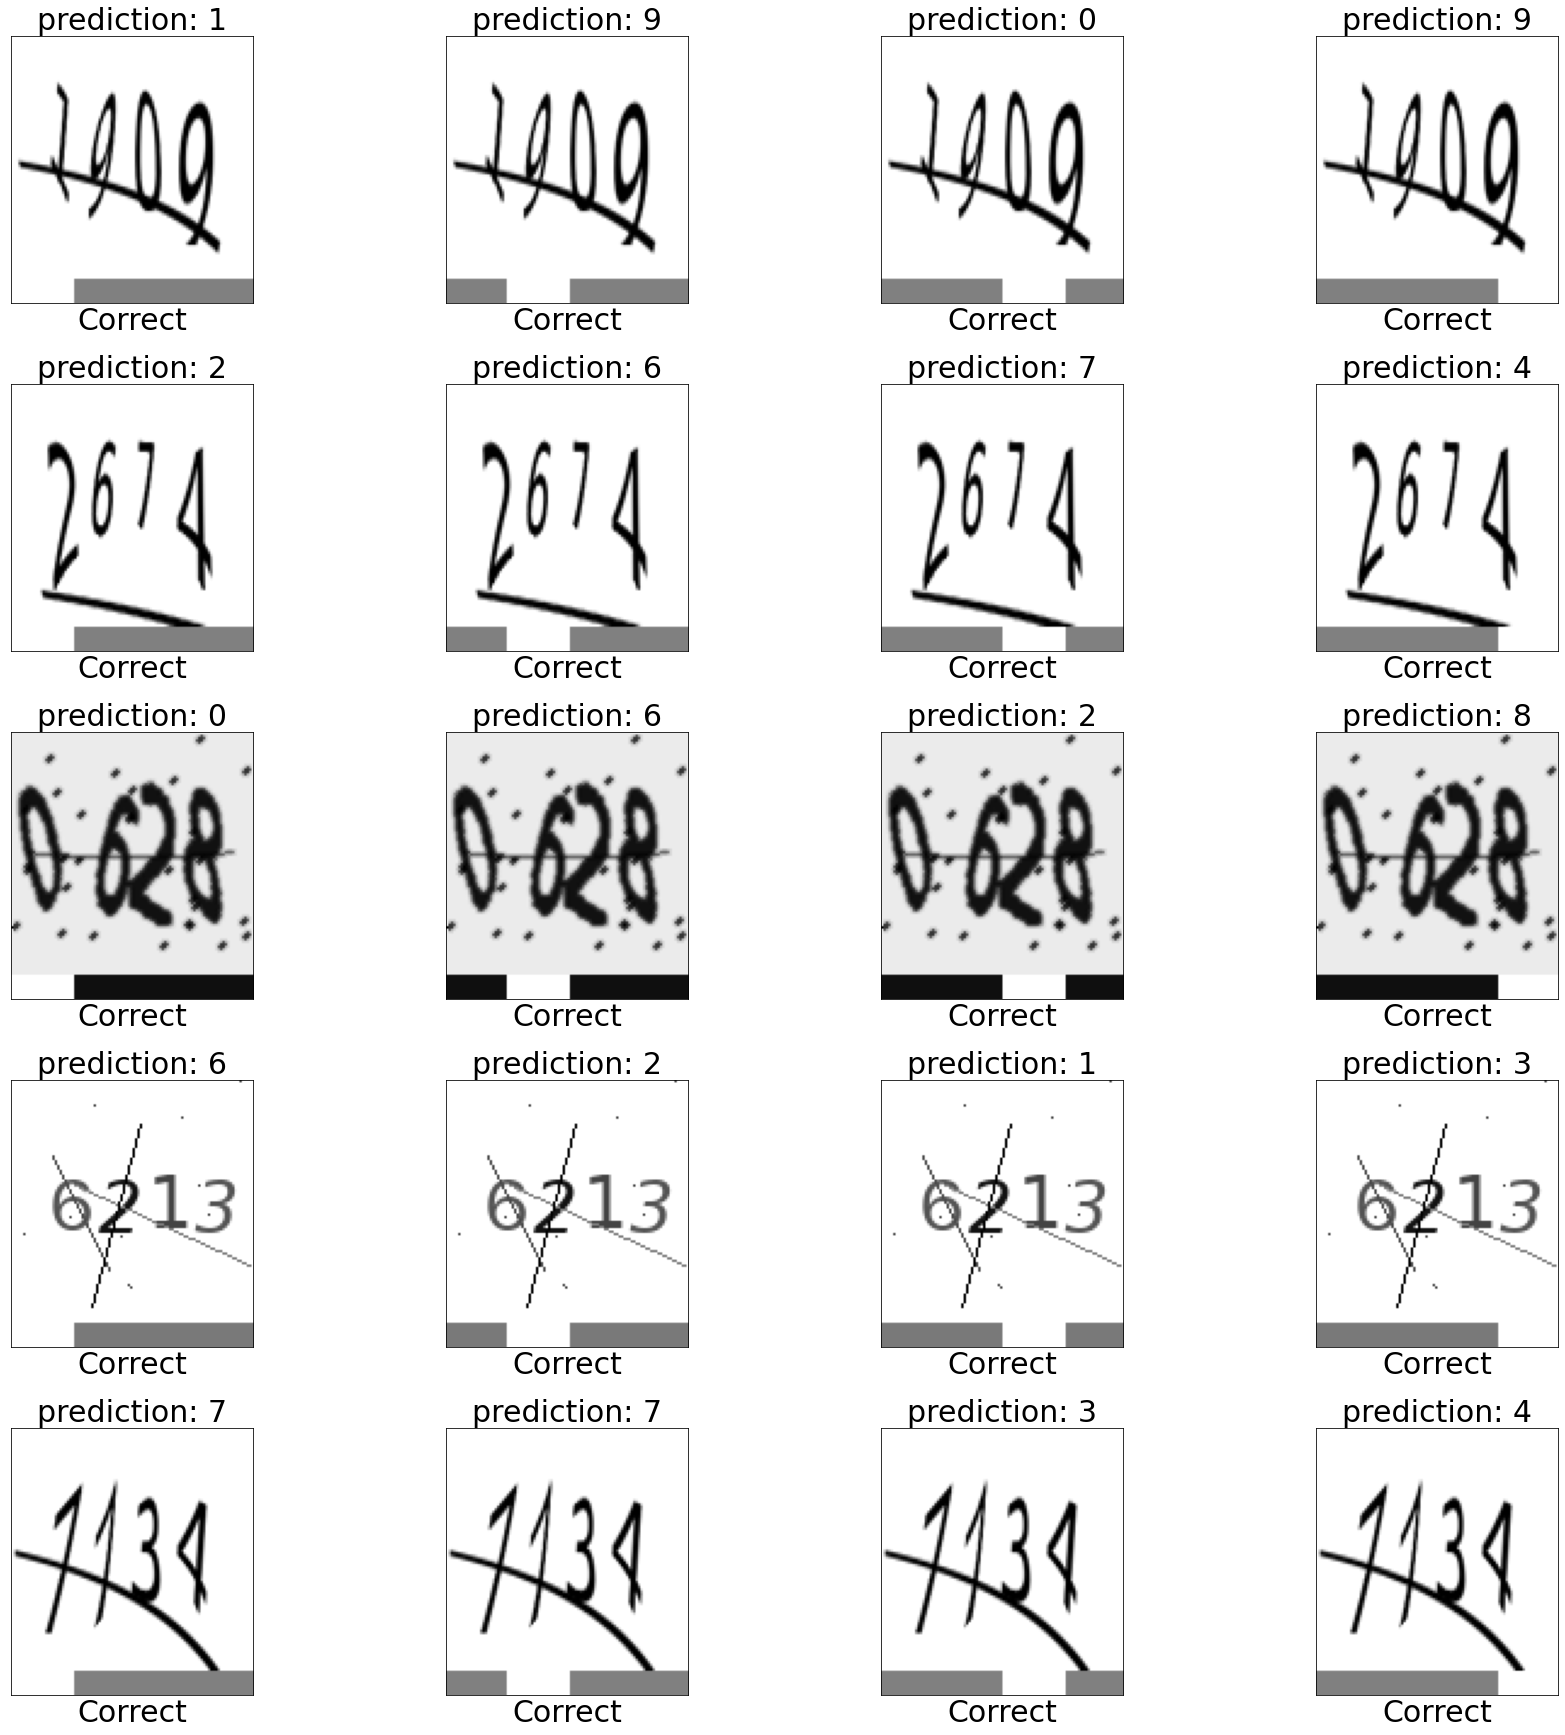

In [11]:
def display_predictions_inline(captcha_images, predictions, true_values, total_to_display, columns):
    """
        Display a plot showing the results of the model's predictions.
        Each subplot will contain the CAPTCHA image, the model's prediction value, and the true value (label).
        
    Args:
        captcha_images (PNG image): the CAPTCHA image file
        
        predictions (EagerTensor): the prediction value made by the model
        
        true_values (EagerTensor): the label associated with the CAPTCHA image
        
        total_to_display (int): total number of subplots
        
        columns (int): number of columns in the plot
    """
    random_indices = numpy.random.permutation(total_to_display)
    rows = math.ceil(total_to_display / columns)

    figure, axes = pyplot.subplots(rows, columns, figsize=(25, 25))
    figure.tight_layout(pad=6.0)
    
    for image_index in range(total_to_display):
        result = axes.flat[image_index]
        result.imshow(captcha_images[image_index], cmap='gray')
        
        grade = None
        prediction = predictions[image_index].numpy()
        answer = true_values[image_index].numpy()
        
        if prediction == answer:
            grade = 'Correct'
        else:
            grade = 'Wrong, answer is ' + str(answer) 
        
        result.set_title('prediction: {}'.format(str(prediction)), fontsize=30)
        result.set_xlabel(grade, fontsize=30)

        result.set_xticks([])
        result.set_yticks([])

display_predictions_inline(captcha_images, 
                           predictions, 
                           true_values,
                           20,
                           4)